# Modèle d'entraînement et de test

## Splitting du dataset

In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [47]:
loan_df=pd.read_csv("../data/Loan_clean.csv")

In [48]:
# Séparation des features et des targets
X = loan_df.drop("Loan_Status", axis=1)
y = loan_df["Loan_Status"]

In [49]:
#Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) #80% train, 20% test(0.2)


print("train :", X_train.shape)
print("test :", X_test.shape)

train : (491, 15)
test : (123, 15)


## Transformation

In [50]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np
from imblearn.over_sampling import SMOTE

Variable catégorielle  --> Encodage en numérique

In [51]:
vlr_numerique = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount_log", "InterestRate"]
vlr_categorie = ["Gender", "Married", "Dependents","Education", "Self_Employed", "Property_Area"]


encoder=OneHotEncoder(drop='first', handle_unknown='ignore')
x_train_categorie = encoder.fit_transform(X_train[vlr_categorie])
x_test_categorie = encoder.transform(X_test[vlr_categorie])

Mise à l'échelle des vlr numériques

In [52]:
scaler=StandardScaler()
x_train_numerique = scaler.fit_transform(X_train[vlr_numerique])
x_test_numerique = scaler.transform(X_test[vlr_numerique])

Fusion des valeurs numériques et catégorielles

In [53]:
X_train_final = np.hstack((x_train_numerique, x_train_categorie.toarray()))
X_test_final = np.hstack((x_test_numerique, x_test_categorie.toarray()))

print("X_train_final shape :", X_train_final.shape)
print("X_test_final shape :", X_test_final.shape)

X_train_final shape : (491, 13)
X_test_final shape : (123, 13)


In [54]:
#Réequilibrage des données avec SMOTE
print("Avant SMOTE:", np.bincount(y_train))
smote = SMOTE(random_state=42)
X_train_final, y_train = smote.fit_resample(X_train_final, y_train)
print("Après SMOTE:", np.bincount(y_train))

Avant SMOTE: [154 337]
Après SMOTE: [337 337]


In [55]:
print("NaN dans X_train :", np.isnan(X_train_final).sum())
print("NaN dans X_test  :", np.isnan(X_test_final).sum())

NaN dans X_train : 0
NaN dans X_test  : 0


## Entraînement des modèles

In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [78]:
from sklearn.model_selection import cross_validate

def cross_val_score(model, X, y, cv=5, scoring="f1"):
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring)
    test_scores = scores["test_score"]
    print(f"{scoring} scores: {test_scores}")
    mean_score = test_scores.mean()
    print(f"Mean {scoring} score: {mean_score:.3f}")
    return mean_score

# Example usage:
# mean_score = cross_validated_score(log_reg, X_train_final, y_train)

#### Régression Logistique

In [80]:
log_reg = LogisticRegression(max_iter=1000, random_state=42) #Creation du modèle
# Validation croisée
#cv_scores = cross_val_score(log_reg, X_train_final, y_train, cv=5, scoring="f1")
#print("F1-score (CV):", cv_scores.mean())
log_reg.fit(X_train_final, y_train) #Entrainement du modèle avec fit

#Prédictions
y_pred_log = log_reg.predict(X_test_final)
y_proba_log = log_reg.predict_proba(X_test_final)[:, 1]

# Évaluation des métriques
print("Accuracy :", accuracy_score(y_test, y_pred_log))
print("Precision:", precision_score(y_test, y_pred_log, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred_log, zero_division=0))
print("F1       :", f1_score(y_test, y_pred_log, zero_division=0))
print("ROC AUC  :", roc_auc_score(y_test, y_proba_log))
print("\nClassification report:\n", classification_report(y_test, y_pred_log, zero_division=0))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_log))

Accuracy : 0.5609756097560976
Precision: 0.7384615384615385
Recall   : 0.5647058823529412
F1       : 0.64
ROC AUC  : 0.6294117647058823

Classification report:
               precision    recall  f1-score   support

           0       0.36      0.55      0.44        38
           1       0.74      0.56      0.64        85

    accuracy                           0.56       123
   macro avg       0.55      0.56      0.54       123
weighted avg       0.62      0.56      0.58       123

Confusion matrix:
 [[21 17]
 [37 48]]


#### Arbre de décision

In [58]:
dt = DecisionTreeClassifier(random_state=42) 
dt.fit(X_train_final, y_train)

y_pred_dt = dt.predict(X_test_final)
y_proba_dt = dt.predict_proba(X_test_final)[:, 1]

print("Accuracy :", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred_dt, zero_division=0))
print("F1       :", f1_score(y_test, y_pred_dt, zero_division=0))
print("ROC AUC  :", roc_auc_score(y_test, y_proba_dt))
print("\nClassification report:\n", classification_report(y_test, y_pred_dt, zero_division=0))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_dt))

Accuracy : 0.45528455284552843
Precision: 0.618421052631579
Recall   : 0.5529411764705883
F1       : 0.5838509316770186
ROC AUC  : 0.39489164086687306

Classification report:
               precision    recall  f1-score   support

           0       0.19      0.24      0.21        38
           1       0.62      0.55      0.58        85

    accuracy                           0.46       123
   macro avg       0.40      0.39      0.40       123
weighted avg       0.49      0.46      0.47       123

Confusion matrix:
 [[ 9 29]
 [38 47]]


#### Random Forest

In [59]:
rf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced")
rf.fit(X_train_final, y_train)

y_pred_rf = rf.predict(X_test_final)
y_proba_rf = rf.predict_proba(X_test_final)[:, 1]

print("Accuracy :", round(accuracy_score(y_test, y_pred_rf), 2))
print("Precision:", round(precision_score(y_test, y_pred_rf, zero_division=0), 2))
print("Recall   :", round(recall_score(y_test, y_pred_rf, zero_division=0), 2))
print("F1       :", round(f1_score(y_test, y_pred_rf, zero_division=0), 2))
print("ROC AUC  :", round(roc_auc_score(y_test, y_proba_rf), 2))
print("\nClassification report:\n", classification_report(y_test, y_pred_rf, zero_division=0))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_rf))

Accuracy : 0.66
Precision: 0.71
Recall   : 0.85
F1       : 0.77
ROC AUC  : 0.54

Classification report:
               precision    recall  f1-score   support

           0       0.41      0.24      0.30        38
           1       0.71      0.85      0.77        85

    accuracy                           0.66       123
   macro avg       0.56      0.54      0.54       123
weighted avg       0.62      0.66      0.63       123

Confusion matrix:
 [[ 9 29]
 [13 72]]


#### AdaBoost

In [60]:

ada = AdaBoostClassifier(n_estimators=300, random_state=42)
ada.fit(X_train_final, y_train)

y_pred_ada = ada.predict(X_test_final)
y_proba_ada = ada.predict_proba(X_test_final)[:, 1]

print("Accuracy :", round(accuracy_score(y_test, y_pred_ada), 2))
print("Precision:", round(precision_score(y_test, y_pred_ada, zero_division=0), 2))
print("Recall   :", round(recall_score(y_test, y_pred_ada, zero_division=0), 2))
print("F1       :", round(f1_score(y_test, y_pred_ada, zero_division=0), 2))
print("ROC AUC  :", round(roc_auc_score(y_test, y_proba_ada), 2))
print("\nClassification report:\n", classification_report(y_test, y_pred_ada, zero_division=0))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_ada))

c:\Users\pemab\Documents\Projet_fin_etude\Prediction_approbation_pret\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy : 0.61
Precision: 0.7
Recall   : 0.75
F1       : 0.73
ROC AUC  : 0.48

Classification report:
               precision    recall  f1-score   support

           0       0.34      0.29      0.31        38
           1       0.70      0.75      0.73        85

    accuracy                           0.61       123
   macro avg       0.52      0.52      0.52       123
weighted avg       0.59      0.61      0.60       123

Confusion matrix:
 [[11 27]
 [21 64]]


#### Linear Discriminant Analysis (LDA)

In [61]:
lda = LinearDiscriminantAnalysis(solver="lsqr", shrinkage="auto")  # stable avec beaucoup d'OHE
lda.fit(X_train_final, y_train)

y_pred_lda = lda.predict(X_test_final)
# LDA renvoie des proba
y_proba_lda = lda.predict_proba(X_test_final)[:, 1]

print("Accuracy :", round(accuracy_score(y_test, y_pred_lda), 2))
print("Precision:", round(precision_score(y_test, y_pred_lda, zero_division=0), 2))
print("Recall   :", round(recall_score(y_test, y_pred_lda, zero_division=0), 2))
print("F1       :", round(f1_score(y_test, y_pred_lda, zero_division=0), 2))
print("ROC AUC  :", round(roc_auc_score(y_test, y_proba_lda), 2))
print("\nClassification report:\n", classification_report(y_test, y_pred_lda, zero_division=0))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_lda))

Accuracy : 0.53
Precision: 0.71
Recall   : 0.53
F1       : 0.61
ROC AUC  : 0.61

Classification report:
               precision    recall  f1-score   support

           0       0.33      0.53      0.41        38
           1       0.71      0.53      0.61        85

    accuracy                           0.53       123
   macro avg       0.52      0.53      0.51       123
weighted avg       0.60      0.53      0.55       123

Confusion matrix:
 [[20 18]
 [40 45]]


#### XGBoost

In [62]:
xgb = XGBClassifier(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    objective="binary:logistic",
    eval_metric="logloss"
)
xgb.fit(X_train_final, y_train)

y_pred_xgb = xgb.predict(X_test_final)
y_proba_xgb = xgb.predict_proba(X_test_final)[:, 1]

print("Accuracy :", round(accuracy_score(y_test, y_pred_xgb), 2))
print("Precision:", round(precision_score(y_test, y_pred_xgb, zero_division=0), 2))
print("Recall   :", round(recall_score(y_test, y_pred_xgb, zero_division=0), 2))
print("F1       :", round(f1_score(y_test, y_pred_xgb, zero_division=0), 2))
print("ROC AUC  :", round(roc_auc_score(y_test, y_proba_xgb), 2))
print("\nClassification report:\n", classification_report(y_test, y_pred_xgb, zero_division=0))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_xgb))

Accuracy : 0.6
Precision: 0.7
Recall   : 0.73
F1       : 0.72
ROC AUC  : 0.5

Classification report:
               precision    recall  f1-score   support

           0       0.34      0.32      0.33        38
           1       0.70      0.73      0.72        85

    accuracy                           0.60       123
   macro avg       0.52      0.52      0.52       123
weighted avg       0.59      0.60      0.60       123

Confusion matrix:
 [[12 26]
 [23 62]]


### Comparaison des performances

In [63]:
# Dictionnaire vide pour stocker les résultats
results = {}

# Liste des modèles déjà entraînés
models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf,
    "Decision Tree": dt,
    "XGBoost": xgb,
    "AdaBoost": ada,
    "LDA": lda
}

# Boucle pour calculer les métriques
for name, model in models.items():
    y_pred = model.predict(X_test_final)
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, model.predict_proba(X_test_final)[:,1])
    }

In [64]:

results_df = pd.DataFrame(results).T
display(results_df)

,Accuracy,Precision,Recall,F1,ROC-AUC
Logistic Regression,0.560976,0.738462,0.564706,0.640000,0.629412
Random Forest,0.658537,0.712871,0.847059,0.774194,0.538854
Decision Tree,0.455285,0.618421,0.552941,0.583851,0.394892
XGBoost,0.601626,0.704545,0.729412,0.716763,0.501238
AdaBoost,0.609756,0.703297,0.752941,0.727273,0.476471
LDA,0.528455,0.714286,0.529412,0.608108,0.613003


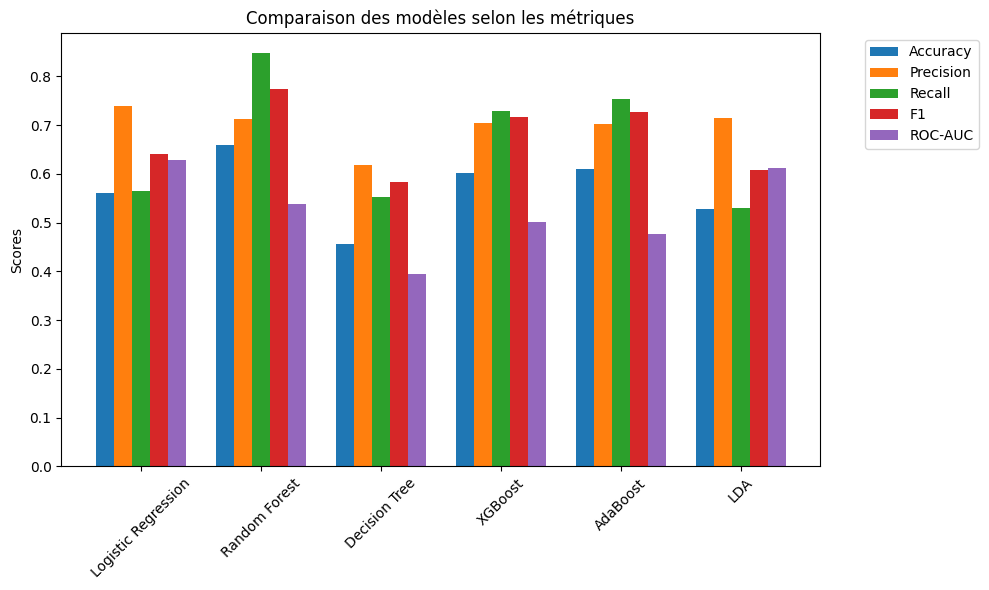

In [65]:
results_df = pd.DataFrame(results).T
models_list = results_df.index  # model names
x = np.arange(len(models_list))
width = 0.15

fig, ax = plt.subplots(figsize=(10, 6))
for i, metric in enumerate(results_df.columns):
    ax.bar(x + i * width, results_df[metric], width, label=metric)

ax.set_xticks(x + width * 2)
ax.set_xticklabels(models_list, rotation=45)
ax.set_ylabel("Scores")
ax.set_title("Comparaison des modèles selon les métriques")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # legend on the right

plt.tight_layout()
plt.show()

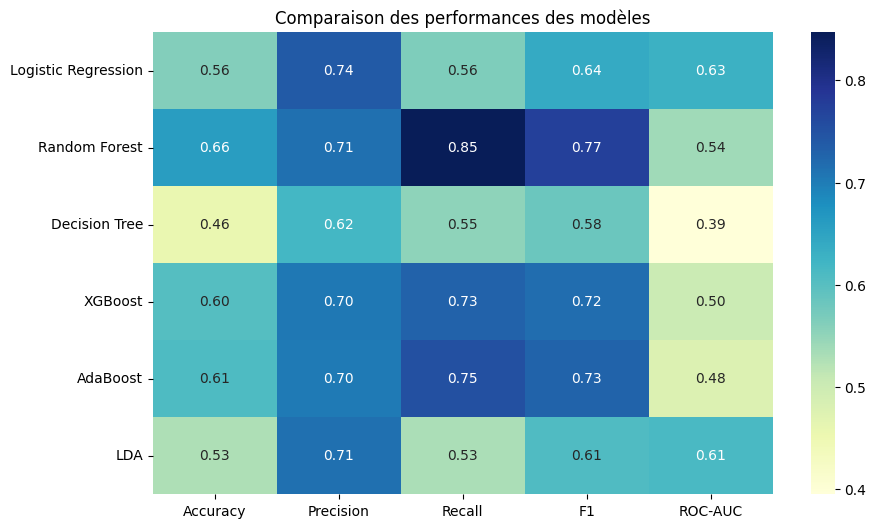

In [66]:
# Visualisation 1: Heatmap des performances globales des modèles
plt.figure(figsize=(10, 6))
sns.heatmap(results_df, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Comparaison des performances des modèles")
plt.show()

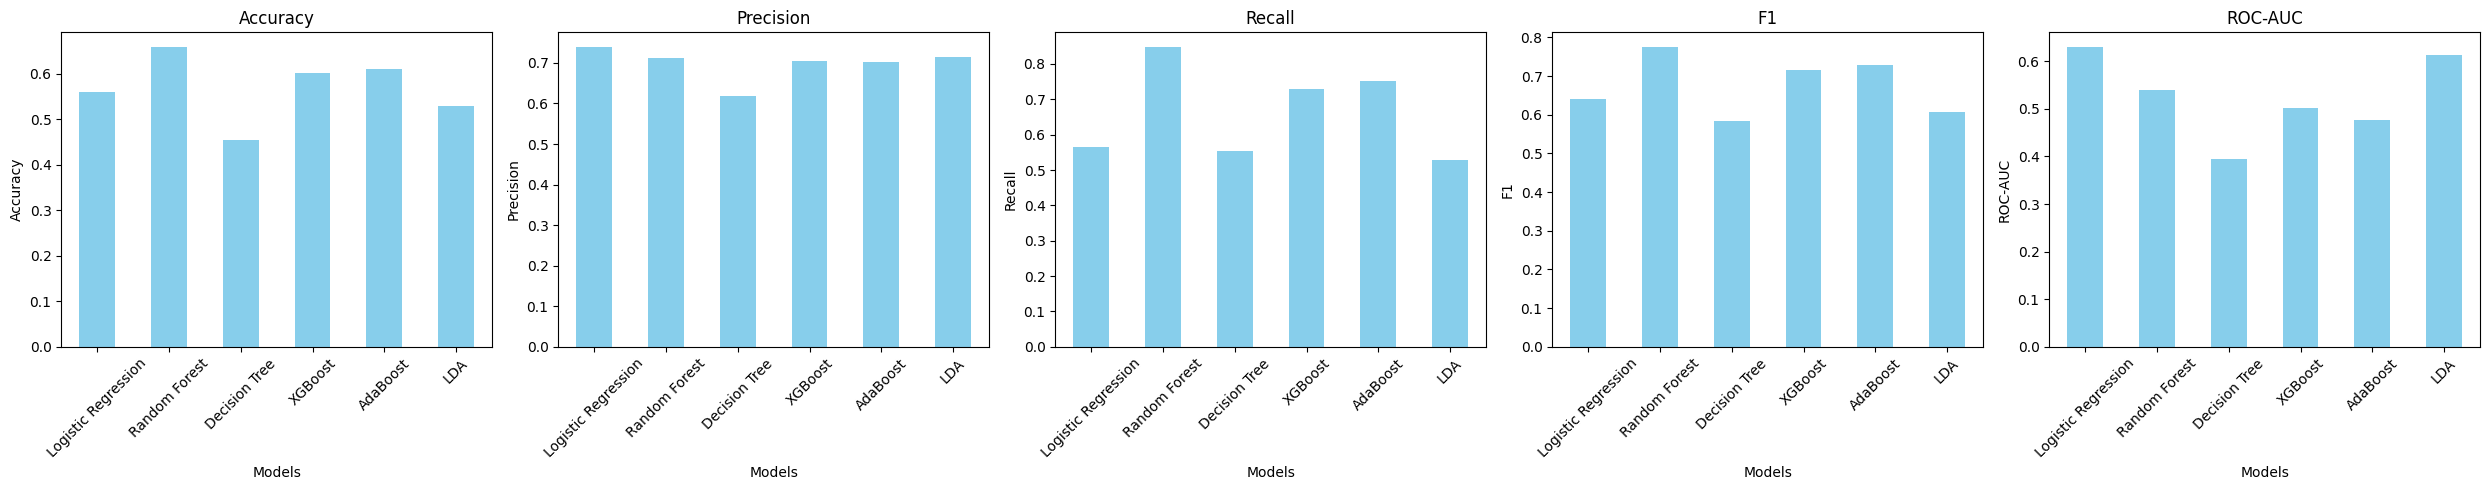

In [67]:
# Plot each metric separately for comparison across models

results_df = pd.DataFrame(results).T
metrics = results_df.columns
n_metrics = len(metrics)

fig, axes = plt.subplots(1, n_metrics, figsize=(5 * n_metrics, 5))

for i, metric in enumerate(metrics):
    results_df[metric].plot(kind='bar', ax=axes[i], title=metric, color='skyblue')
    axes[i].set_xlabel('Models')
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [68]:
# Calculer la moyenne des valeurs des métriques pour chaque modèle et trier dans l'ordre croissant
results_df = pd.DataFrame(results).T
average_metrics = results_df.mean(axis=1).sort_values(ascending=False)
print(average_metrics)

Random Forest          0.706303
AdaBoost               0.653947
XGBoost                0.650717
Logistic Regression    0.626711
LDA                    0.598653
Decision Tree          0.521078
dtype: float64


### Choix du meilleur modèle

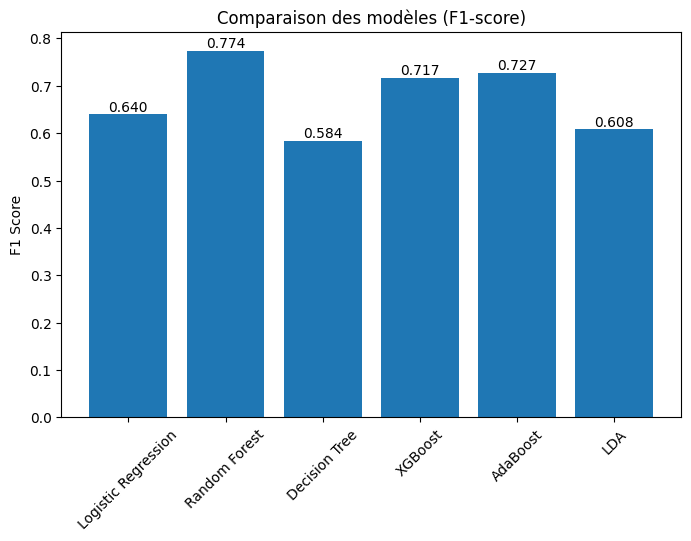

In [69]:
results_df = pd.DataFrame(results).T
plt.figure(figsize=(8,5))
bars = plt.bar(results_df.index, results_df["F1"])
plt.xticks(rotation=45)
plt.ylabel("F1 Score")
plt.title("Comparaison des modèles (F1-score)")

# Add F1-score values on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.3f}', ha='center', va='bottom')

plt.show()


In [70]:
# 1. Trier les modèles par F1-score (du meilleur au moins bon)
sorted_df = results_df.sort_values('F1', ascending=False)

# 2. Filtrer les modèles avec un F1 proche du maximum (ici à 0.01 près, ajustable)
f1_max = sorted_df['F1'].iloc[0]
f1_gap = 0.01
candidats = sorted_df[sorted_df['F1'] >= f1_max - f1_gap]
print("\nModèles proches du meilleur F1-score (écart <= 0.0.1) :")
display(candidats[['F1', 'ROC-AUC']])

# 3. Parmi les candidats, choisir celui avec le ROC-AUC le plus élevé
final_model = candidats.sort_values('ROC-AUC', ascending=False).iloc[0]
final_name = candidats.sort_values('ROC-AUC', ascending=False).index[0]



Modèles proches du meilleur F1-score (écart <= 0.0.1) :


,F1,ROC-AUC
Random Forest,0.774194,0.538854


In [71]:
print("Meilleur modèle :", final_name)
print("Détails du modèle :", final_model)

Meilleur modèle : Random Forest
Détails du modèle : Accuracy     0.658537
Precision    0.712871
Recall       0.847059
F1           0.774194
ROC-AUC      0.538854
Name: Random Forest, dtype: float64


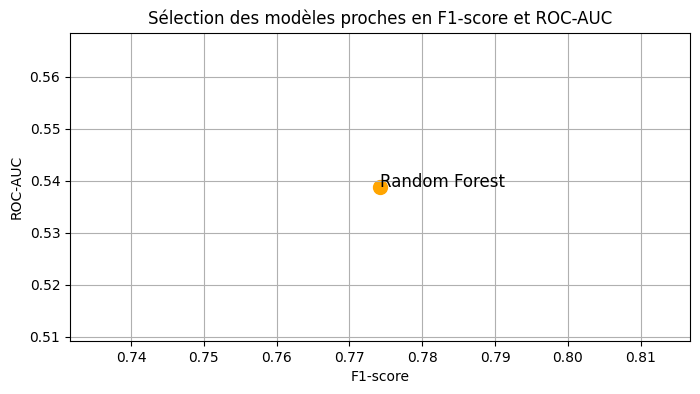

In [72]:
plt.figure(figsize=(8,4))
plt.scatter(candidats['F1'], candidats['ROC-AUC'], color='orange', s=100)
for idx in candidats.index:
    plt.text(candidats.loc[idx,'F1'], candidats.loc[idx,'ROC-AUC'], idx, fontsize=12)
plt.xlabel("F1-score")
plt.ylabel("ROC-AUC")
plt.title("Sélection des modèles proches en F1-score et ROC-AUC")
plt.grid(True)
plt.show()

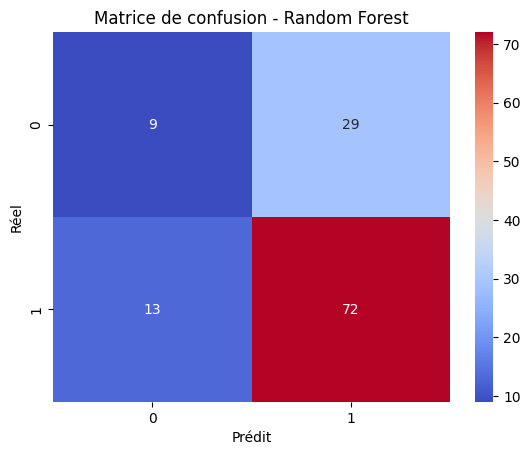

In [73]:
from sklearn.metrics import confusion_matrix

# Création de la matrice de confusion pour le meilleur modèle (final_model)

y_best_pred = models[final_name].predict(X_test_final)
cm_best = confusion_matrix(y_test, y_best_pred)

sns.heatmap(cm_best, annot=True, fmt='d', cmap='coolwarm')
plt.title(f"Matrice de confusion - {final_name}")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

## Tests et validation

In [ ]:
from sklearn.model_selection import cross_val_score
#Vérifie que le modèle est stable
# Le dataset train est decoupé en 5 parties, 4 pour l'entrainement et 1 pour le test --> Meilleure estimation

scores_f1 = cross_val_score(models[final_name], X_train_final, y_train, cv=5, scoring="f1")
print("F1-score moyen (CV):", np.mean(scores_f1))


F1-score moyen (CV): 0.7567123278040825


Réentraînement du modèle final sur tous le dataset train

In [ ]:
models[final_name].fit(X_train_final, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=300,
                       random_state=42)

#### Evaluation finale sur les données de test

In [ ]:
y_pred = models[final_name].predict(X_test_final)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.41      0.24      0.30        38
           1       0.71      0.85      0.77        85

    accuracy                           0.66       123
   macro avg       0.56      0.54      0.54       123
weighted avg       0.62      0.66      0.63       123

[[ 9 29]
 [13 72]]


#### Sauvegarde du modèle

In [ ]:
import joblib
joblib.dump(models[final_name], "../models/best_model.pkl")

['../models/best_model.pkl']

#### Comparaison scores train vs test

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import joblib
best_model = joblib.load("../models/best_model.pkl")
# Prédictions
y_train_pred = best_model.predict(X_train_final)
y_test_pred = best_model.predict(X_test_final)

# Calcul des métriques
metrics = {
    "Accuracy": (
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test, y_test_pred)
    ),
    "F1-score": (
        f1_score(y_train, y_train_pred),
        f1_score(y_test, y_test_pred)
    ),
    "Recall": (
        recall_score(y_train, y_train_pred),
        recall_score(y_test, y_test_pred)
    ),
    "Precision": (
        precision_score(y_train, y_train_pred),
        precision_score(y_test, y_test_pred)
    )
}

# Affichage comparatif
print("Métriques (train vs test) :\n")
for m, (train_val, test_val) in metrics.items():
    print(f"{m}: Train = {train_val:.3f} | Test = {test_val:.3f}")


Métriques (train vs test) :

Accuracy: Train = 1.000 | Test = 0.659
F1-score: Train = 1.000 | Test = 0.774
Recall: Train = 1.000 | Test = 0.847
Precision: Train = 1.000 | Test = 0.713
